<a href="https://colab.research.google.com/github/dlevonian/california_renewables/blob/master/caiso_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CAISO SOLAR

In [0]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt

import time
from datetime import datetime

In [216]:
import tensorflow as tf
from tensorflow import keras

tf.__version__

'2.2.0-rc4'

In [217]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
path = '/content/drive/My Drive/NYCDSA/california_renewables/'  # Google Drive path

In [0]:
df = pd.read_csv(path+'caiso_final.csv')

In [220]:
df.head(5)

,DATE,HOUR,GEOTHERMAL,BIOMASS,BIOGAS,SMALL_HYDRO,WIND,SOLAR_PV,SOLAR_THERMAL,RENEWABLES,NUCLEAR,THERMAL,IMPORTS,HYDRO,TOTAL
0,20100420,1,1056,323,170,250,632,0,0,2431,3854,7707,4964,2514,21470
1,20100420,2,1055,318,169,245,632,0,0,2419,3859,7357,4651,2012,20298
2,20100420,3,1058,316,168,240,677,0,0,2460,3870,6765,4667,1914,19676
3,20100420,4,1063,318,168,238,923,0,0,2710,3887,6544,4823,1902,19866
4,20100420,5,1066,318,168,247,875,0,0,2674,3894,6623,4835,2213,20239


In [0]:
def datetime_from_integers(date_int, hour_int):
    date_str = str(date_int)
    hour_str = str(hour_int-1) 
    if len(hour_str)==1: hour_str='0'+hour_str
    return datetime.strptime(date_str+hour_str, '%Y%m%d%H')
dt = list(map(datetime_from_integers, df.DATE.values, df.HOUR.values))

In [222]:
df.dtypes

DATE             int64
HOUR             int64
GEOTHERMAL       int64
BIOMASS          int64
BIOGAS           int64
SMALL_HYDRO      int64
WIND             int64
SOLAR_PV         int64
SOLAR_THERMAL    int64
RENEWABLES       int64
NUCLEAR          int64
THERMAL          int64
IMPORTS          int64
HYDRO            int64
TOTAL            int64
dtype: object

In [223]:
df.shape

(87936, 15)

In [0]:
# PREDICT SOLAR
series = df['SOLAR_PV'].values + df['SOLAR_THERMAL'].values

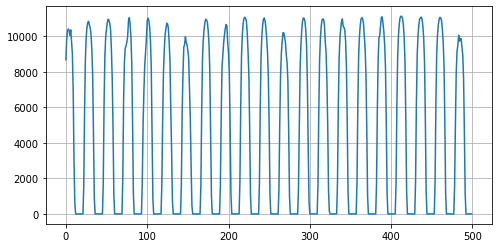

In [225]:
plt.figure(figsize=(8,4))
plt.plot(series[80_000:80_500])
plt.grid()

In [0]:
split_time = 76_272    # January 1, 2019, 00:00

time_train = dt[:split_time]
x_train = series[:split_time]

time_test = dt[split_time:]
x_test = series[split_time:]


## Naive Forecast

In [0]:
naive_forecast = series[split_time-1:-1]

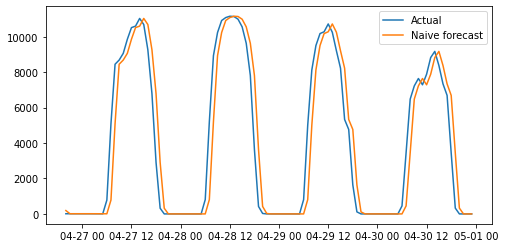

In [228]:
plt.figure(figsize=(8,4))
plt.plot(time_test[-100:], x_test[-100:], label='Actual')
plt.plot(time_test[-100:], naive_forecast[-100:], label='Naive forecast')
plt.legend()
plt.show()

In [229]:
print(keras.metrics.mean_squared_error(x_test, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_test, naive_forecast).numpy())

1930753
738


## MA+Differencing

In [0]:
def moving_average_forecast(series, window_size):
    """Forecasts the mean of the last window_size values.
        If window_size=1, then this is equivalent to naive forecast"""
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)

In [0]:
window_size=24
moving_avg = moving_average_forecast(series, window_size)#[-240:]

In [0]:
ma_forecast = moving_avg[split_time-window_size-1:-1]

In [233]:
print(keras.metrics.mean_squared_error(x_test, ma_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_test, ma_forecast).numpy())

14501363.665356396
3442.341681670096


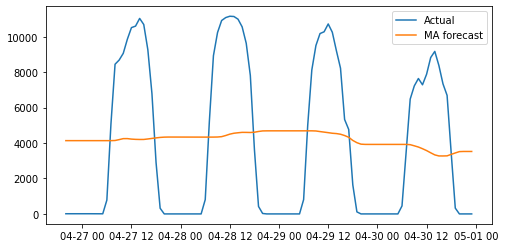

In [234]:
plt.figure(figsize=(8,4))
plt.plot(time_test[-100:], x_test[-100:], label='Actual')
plt.plot(time_test[-100:], ma_forecast[-100:], label='MA forecast')
plt.legend()
plt.show()

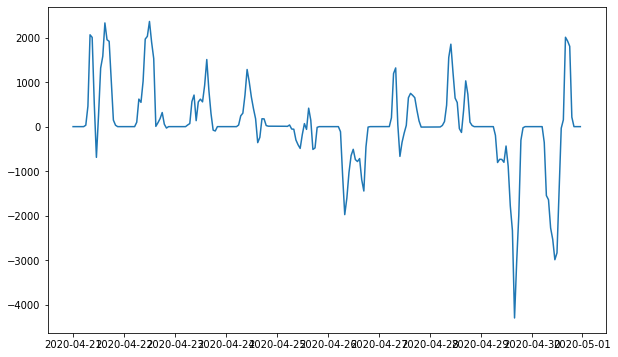

In [235]:
# DIFFERENCING - PERIOD = 24H
diff_series = (series[24:] - series[:-24])
diff_time = dt[24:]

display_window = 240
plt.figure(figsize=(10, 6))
plt.plot(diff_time[-display_window:], diff_series[-display_window:])
plt.show()

In [0]:
w = 2
diff_moving_avg = moving_average_forecast(diff_series, w)[split_time - 24 - w:]
diff_forecast =\
moving_average_forecast(series[split_time - int(24+w/2):-int(24-w/2)], w) + diff_moving_avg
diff_forecast=np.floor(np.maximum(0,diff_forecast))


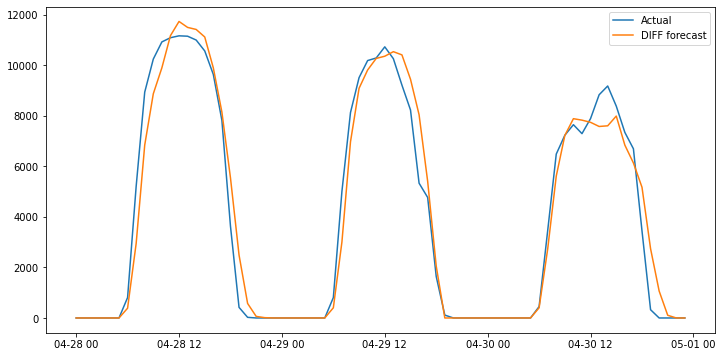

In [237]:
display_window = 72
plt.figure(figsize=(12, 6))
plt.plot(time_test[-display_window:], x_test[-display_window:], label='Actual')
plt.plot(time_test[-display_window:], diff_forecast[-display_window:], label='DIFF forecast')
plt.legend()
plt.show()

In [238]:
print(keras.metrics.mean_squared_error(x_test, diff_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_test, diff_forecast).numpy())

680881.672239369
448.6856138545953


## Conv1D+LSTMs

In [0]:
# reproducibility
tf.random.set_seed(2020)
np.random.seed(2020)


In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = series[..., np.newaxis]
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


In [0]:
window_size =  168
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
x_train = x_train[-20_000:]

In [0]:
train_set = windowed_dataset(x_train, 
                             window_size=window_size, 
                             batch_size=batch_size, 
                             shuffle_buffer=shuffle_buffer_size)

val_set = windowed_dataset(x_test, 
                             window_size=window_size, 
                             batch_size=batch_size, 
                             shuffle_buffer=shuffle_buffer_size)


In [244]:
train_set.element_spec

(TensorSpec(shape=(None, None, 1), dtype=tf.int64, name=None),
 TensorSpec(shape=(None, None, 1), dtype=tf.int64, name=None))

In [245]:
model = tf.keras.models.Sequential([

    tf.keras.layers.Conv1D( filters=128, 
                            kernel_size=8,
                            strides=1, 
                            padding="causal",
                            activation="relu",
                            input_shape=[None, 1]),

    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),

    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, None, 128)         1152      
_________________________________________________________________
lstm_20 (LSTM)               (None, None, 64)          49408     
_________________________________________________________________
lstm_21 (LSTM)               (None, None, 64)          33024     
_________________________________________________________________
dense_30 (Dense)             (None, None, 64)          4160      
_________________________________________________________________
dense_31 (Dense)             (None, None, 32)          2080      
_________________________________________________________________
dense_32 (Dense)             (None, None, 1)           33        
Total params: 89,857
Trainable params: 89,857
Non-trainable params: 0
_________________________________________________

In [0]:
model.compile(loss='mae',   
              optimizer=tf.keras.optimizers.Adam(lr=1e-3),
              metrics=['mae'])


In [0]:
def scheduler(epoch, lr):
    # keep the original lr for flat_period epochs, exponential decay since then subject to floor_lr
    flat_period, decay, floor_lr = (10, -0.025, 0.0001)
    if epoch<flat_period:   
        return lr
    else:  
        return max(lr*np.exp(decay), floor_lr)

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)


In [0]:
EPOCHS=100

tic = time.time()
history = model.fit(train_set, 
                    epochs=EPOCHS,  
                    validation_data=val_set,
                    callbacks=[lr_callback],
                    verbose=1)

toc = time.time()
print(f'complete {toc-tic:.2f}')

In [0]:
def model_forecast(model, series, window_size):
    series = series[..., np.newaxis]
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast


In [250]:
tic = time.time()
lstm_forecast = model_forecast(model, series, window_size)

toc = time.time()
print(f'complete {toc-tic:.2f}')

lstm_forecast.shape

complete 32.29


(87769, 168, 1)

In [0]:
lstm_forecast = np.squeeze(lstm_forecast[split_time - window_size:-1, -1, 0])
lstm_forecast = np.floor(np.maximum(0, lstm_forecast))

In [252]:
print(keras.metrics.mean_squared_error(x_test, lstm_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_test, lstm_forecast).numpy())

115736.87
185.73268


In [0]:
# 168 hours    kernel_size=8
# 115736.87
# 185.73268

In [253]:
print(lstm_forecast.shape)
print(naive_forecast.shape)
print(diff_forecast.shape)

(11664,)
(11664,)
(11664,)


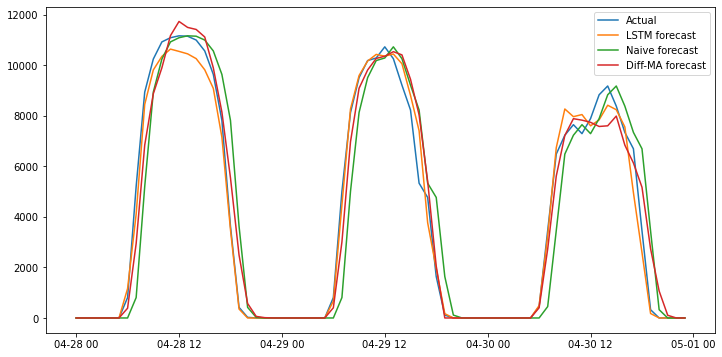

In [254]:
display_window = 72
plt.figure(figsize=(12, 6))
plt.plot(time_test[-display_window:], x_test[-display_window:], label='Actual')
plt.plot(time_test[-display_window:], lstm_forecast[-display_window:], label='LSTM forecast')
plt.plot(time_test[-display_window:], naive_forecast[-display_window:], label='Naive forecast')
plt.plot(time_test[-display_window:], diff_forecast[-display_window:], label='Diff-MA forecast')
plt.legend()
plt.show()

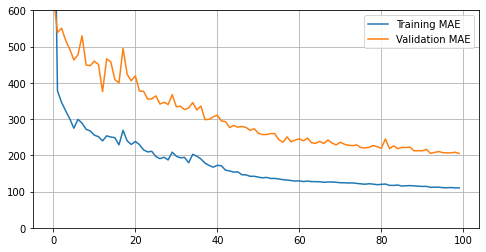

In [255]:
hdict = history.history

mx,val_mx,loss,val_loss = hdict['mae'],hdict['val_mae'],hdict['loss'],hdict['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 4))

plt.plot(epochs_range, mx, label='Training MAE')
plt.plot(epochs_range, val_mx, label='Validation MAE')

plt.ylim(0,600) 
plt.legend()
plt.grid()
plt.show()

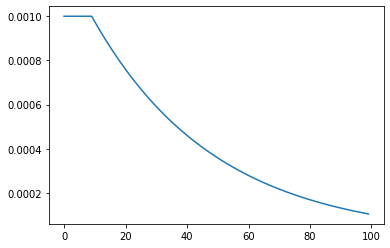

In [256]:
X=np.arange(EPOCHS)
Y=[]
lr=0.001
for x in X:
    lr = scheduler(x, lr)
    Y.append(lr)
plt.plot(X,Y)

## Save Forecasts

In [0]:
forecast_df = pd.DataFrame(data={'DATE':dt[split_time:],
                                 'SOLAR':series[split_time:],
                                 'F_NAIVE':naive_forecast,
                                 'F_DIFF':diff_forecast,
                                 'F_LSTM':lstm_forecast
})

In [0]:
forecast_df.to_csv(path+'caiso_forecasts.csv')